<div class='bar_title'></div>

*Introduction to Data Science*

# Modeling: Part b)

Gunther Gust<br>
Chair of Enterprise AI

Winter Semester 25/26

<img src="https://raw.githubusercontent.com/GuntherGust/tds2_data/main/images/d3.png?raw=1" style="width:20%; float:left;" />

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/ao_modeling.png" style="width:80%" />

# Content

* Predictive Models
    - Random Forests
    - Boosting Methods
* Unsupervised Learning
    - k-Means Clustering
    - Other clustering techniques

Credits: The implementation data examples are adopted from www.kaggle.com.

# Random Forests


Decision Trees (CART) are:
- Easy to interpret  
- Flexible  
- Able to model nonlinear relationships  

But they also have a major weakness:
- __They have extremely high variance:__
    - Small changes in the training data → very different trees  
    - Deep trees can perfectly fit the training data → **overfitting**  
    
High variance harms generalization performance.



In contrast, a shallow tree has **lower variance** but **high bias** (underfitting, the model is "biased" in certain regions of the data)  

It is hard to tune a single tree to achieve __both low bias *and* low variance__, but:

> How about combining many (smaller) trees and average their predictions to reduce variance?

This is exactly what __random forests__ do:

<img src="https://raw.githubusercontent.com/GuntherGust/tds2_data/main/images/03/Random_forest_explain.png?raw=1" style="width:80%; float:left;" />


## Ensemble Learning

A Random Forest is an **ensemble** of decision trees.

Key idea:
- “Many weak learners can create a strong learner.”

Benefit:
- Individual errors tend to cancel out.
- Forest becomes more stable and robust.

### Example: Why Ensembles Improve Accuracy

**Task:** Email classification (SPAM / NOT SPAM)

- We have **3 uncorrelated models**, each with accuracy **70%**.
- The ensemble prediction is made by **majority vote** of the 3 models:


| Outputs of three models     | Probability                        | Ensemble’s output |
|-----------------------------|-------------------------------------|-------------------|
| All three are correct       | `0.7 * 0.7 * 0.7 = 0.343`           | Correct           |
| Only two are correct        | `(0.7 * 0.7 * 0.3) * 3 = 0.441`     | Correct           |
| Only one is correct         | `(0.3 * 0.3 * 0.7) * 3 = 0.189`     | Wrong             |
| None are correct            | `0.3 * 0.3 * 0.3 = 0.027`           | Wrong             |


- Probability that at least **2 models** are correct:

        0.343 + 0.441 = 0.784 
        
- Ensembling __improves accuracy by 8.4%__ 




__Important note:__ The example does not take into account the fact that in real-world applications individial learners are __never perfectly uncorrelated__ - which reduces the gains of ensembling. 

## Training: Bagging (Bootstrap Aggregation)

1. __Bootstrapping__ for building the trees:
    1. Draw a **bootstrap sample** of observations from the training data (= sample with replacement)
    2. Train a CART tree on that sample
    3. Repeat for many trees

> __Effect:__ Each tree sees __*slightly different data*__ and their predictions errors are __*less correlated*__

2. __Aggregation__ for predictions:
- **Classification:** majority vote of all trees  
- **Regression:** average of predictions of all trees

## Random Feature Selection (Feature Bagging)

In addition to bagging, Random Forests randomize the **feature selection** at each split.

At each node:
- Consider only a **random subset** of the overall p features  
  - Classification: often `sqrt(p)`  
  - Regression: often `p/3`

Benefits:
- Trees become more **decorrelated**  
- No single strong predictor dominates the forest  
- Improves generalization

## Hyperparameters

### Model Size
- `n_estimators`: number of trees  
- More trees → better performance (to a point)

### Randomization
- `max_features`: number of features considered at each split  
- `bootstrap`: whether bootstrapping for the trainings samples is used (usually True)

### Sampling
- `max_samples`: size of bootstrap sample  


A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

- A model is trained using k-1 of the folds as training data;
- the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/kfoldcv.png" style="width:70%" />

## Feature Importance

Random Forests provide feature importance estimates:

### 1. Mean Decrease Impurity (MDI)
- Based on how much each feature reduces impurity across splits.

### 2. Permutation Importance
- Shuffle the values of each feature and measure performance drop.
- More reliable and intuitive.

> If shuffling a feature hurts the model, it must be important.

## Strengths of Random Forests

- __Very important:__ High accuracy with minimal tuning  
- Robust against overfitting  
- Handles nonlinearities and feature interactions  
- Works well with mixed data types  
- Provides feature importance  
- No need for feature scaling  


## Weaknesses of Random Forests

- Less interpretable than a single tree  
- Large models (memory-heavy)  
- Slower predictions than individual trees  
- Struggles with very high-dimensional sparse data (e.g., text)  

## Implementing a Random Forest
Thanks to our Scikit-learn modeling pipeline we can reuse most of our code to train a random forest model with 100 trees.

In [13]:
import pandas as pd
import sklearn

In [14]:
melbourne_file_path = 'https://raw.githubusercontent.com/vhaus63/ids_data/refs/heads/main/melb_data.csv'
melbourne_data = pd.read_csv(melbourne_file_path)

melbourne_data.head()

,Unnamed: 0,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [15]:
melbourne_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13580 entries, 0 to 13579
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     13580 non-null  int64  
 1   Suburb         13580 non-null  object 
 2   Address        13580 non-null  object 
 3   Rooms          13580 non-null  int64  
 4   Type           13580 non-null  object 
 5   Price          13580 non-null  float64
 6   Method         13580 non-null  object 
 7   SellerG        13580 non-null  object 
 8   Date           13580 non-null  object 
 9   Distance       13580 non-null  float64
 10  Postcode       13580 non-null  float64
 11  Bedroom2       13580 non-null  float64
 12  Bathroom       13580 non-null  float64
 13  Car            13518 non-null  float64
 14  Landsize       13580 non-null  float64
 15  BuildingArea   7130 non-null   float64
 16  YearBuilt      8205 non-null   float64
 17  CouncilArea    12211 non-null  object 
 18  Lattit

For simplicity we remove rows with missing values for this example. Note that a missing value can sometimes be a valuable information.

In [16]:
print(melbourne_data.shape)
melbourne_data.dropna(axis=0, inplace=True)
print(melbourne_data.shape)

(13580, 22)
(6196, 22)


In [17]:
y = melbourne_data['Price']
y.describe()

count    6.196000e+03
mean     1.068828e+06
std      6.751564e+05
min      1.310000e+05
25%      6.200000e+05
50%      8.800000e+05
75%      1.325000e+06
max      9.000000e+06
Name: Price, dtype: float64

In [18]:
melbourne_features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea',
                        'YearBuilt', 'Lattitude', 'Longtitude']

In [19]:
X = melbourne_data[melbourne_features]

In [20]:
print(X.shape)
X.head()

(6196, 7)


,Rooms,Bathroom,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
1,2,1.0,156.0,79.0,1900.0,-37.8079,144.9934
2,3,2.0,134.0,150.0,1900.0,-37.8093,144.9944
4,4,1.0,120.0,142.0,2014.0,-37.8072,144.9941
6,3,2.0,245.0,210.0,1910.0,-37.8024,144.9993
7,2,1.0,256.0,107.0,1890.0,-37.8060,144.9954


In [21]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Rooms,6196.0,2.931407,0.971079,1.00000,2.000000,3.00000,4.0000,8.00000
Bathroom,6196.0,1.576340,0.711362,1.00000,1.000000,1.00000,2.0000,8.00000
Landsize,6196.0,471.006940,897.449881,0.00000,152.000000,373.00000,628.0000,37000.00000
BuildingArea,6196.0,141.568645,90.834824,0.00000,91.000000,124.00000,170.0000,3112.00000
YearBuilt,6196.0,1964.081988,38.105673,1196.00000,1940.000000,1970.00000,2000.0000,2018.00000
Lattitude,6196.0,-37.807904,0.075850,-38.16492,-37.855438,-37.80225,-37.7582,-37.45709
Longtitude,6196.0,144.990201,0.099165,144.54237,144.926198,144.99580,145.0527,145.52635


In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import numpy as np
import matplotlib.pyplot as plt

In [23]:
# Split data
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, train_size=0.8, test_size=0.2, random_state=0
)

# -----------------------------
# Decision Tree Model
# -----------------------------
tree_model = DecisionTreeRegressor(random_state=1)
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_valid)
tree_mae = mean_absolute_error(y_valid, tree_preds)

# -----------------------------
# Random Forest Model
# -----------------------------
forest_model = RandomForestRegressor(
    random_state=1,
    n_estimators=100
)
forest_model.fit(X_train, y_train)
forest_preds = forest_model.predict(X_valid)
forest_mae = mean_absolute_error(y_valid, forest_preds)

# -----------------------------
# Compare performance
# -----------------------------
print("Decision Tree MAE:     {:.3f}".format(tree_mae))
print("Random Forest MAE:     {:.3f}".format(forest_mae))


Decision Tree MAE:     253848.377
Random Forest MAE:     193739.859


There is likely room for further improvement, but this is a __big improvement over the decision tree error of 253,000__. There are parameters which allow you to change the performance of the Random Forest much as we changed the maximum depth of the single decision tree. But one of the best features of Random Forest models is that they generally work reasonably even __without this tuning.__

Finally, let's use the built-in __feature importance__ method to see which features drive real estate prices in our example:

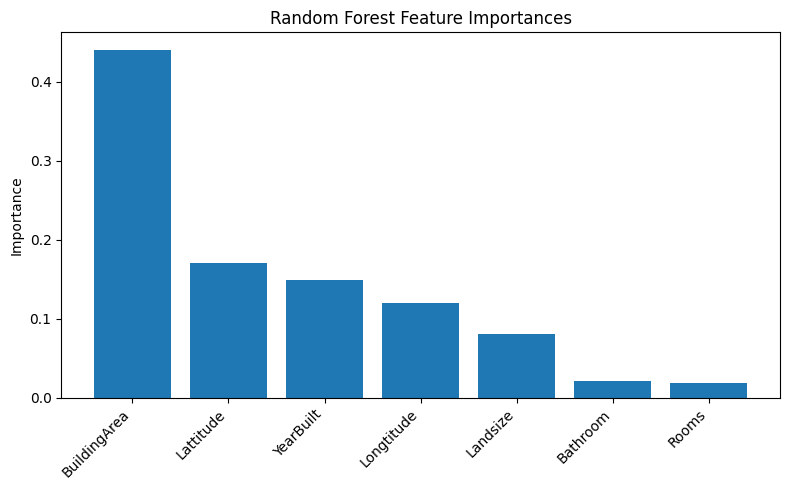

In [25]:
importances = forest_model.feature_importances_

# Put into a DataFrame for nice display
feat_importances = pd.DataFrame(
    {"feature": melbourne_features, "importance": importances}
).sort_values("importance", ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(feat_importances["feature"], feat_importances["importance"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

## Excursus: Beyond Feature Importance — Explainable Machine Learning

Random Forests give us **feature importance values**, but these have limitations:
- They show **how important** a feature is,  
- but not **whether it increases or decreases the prediction**,  
- and not **how the effect changes across different samples**.

There are several __explainability methods__ that can be used with any model and that go further:

- **Permutation Importance**: Measures how performance drops when a feature is shuffled.
 
- **Partial Dependence Plots (PDP)**: Show how the *average* prediction changes with a feature.

- **Individual Conditional Expectation (ICE)**: Shows how predictions change for *individual samples*.

- **LIME (Local Interpretable Model-Agnostic Explanations)**: Explains individual predictions using simple local surrogate models.

- **SHAP(SHapley Additive exPlanations)** : 
    - Shows the **direction** of each feature’s effect (positive / negative),
    - Quantifies how much each feature contributes to **individual predictions**,
    - Separates **global** and **local** explanations,
    - Handles nonlinear interactions naturally.

## More on random forests


- For an informal and illustrative introduction, see [this youtube video](https://www.youtube.com/watch?v=J4Wdy0Wc_xQ&ab_channel=StatQuestwithJoshStarmer). 
- For a formal coverage see [Hastie et al: Elements of Statistical Learning, Chapter 15](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf)


# Mentimeter

Let's recap what we have learned on random forests on [Mentimeter](https://www.menti.com/alurte2x2dno). 

# Boosting algorithms

## Random forest: Bagging 

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/bagging.png" style="width:60%" />

## Another powerful approach: Boosting

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/boosting.png" style="width:70%" />

## What Boosting Does (Intuition)

Boosting builds a model **sequentially**:

1. Train a weak model (usually a very small tree).
2. Identify what it got wrong.
3. Train the next tree to fix these errors.
4. Repeat many times.
5. Combine all trees into one strong predictor.

**Boosting = “Learning from your mistakes.”**

Unlike Random Forests (parallel), boosting trees grow **one after another**,  
each improving the previous model.

## Boosting for regression:

- The next learner fits the **residuals** previous learner (remaining errors).
- Each step reduces the leftover error.

## Boosing for classification:
- Misclassified points implicitly get more influence.
- Hard examples are emphasized.


## Example: Adaboost (Adaptive Boosting)

- Start with equal weights for all training samples.
- After each tree:
  - Misclassified samples get **more weight**.
  - Correctly classified samples get **less weight**.
- The next tree focuses more on "hard" examples.

## Key parameter: Learning rate

In boosting, models are built one after another, and each new model $f_m(x)$ tries to correct the errors of the previous combined model $F_{m-1}(x)$.

But we don’t add the full correction — we only add a **fraction** of it. That fraction is the **learning rate**:

$$
F_m(x) = F_{m-1}(x) + \eta \cdot f_m(x)
$$

Where:

- $F_m(x)$ = ensemble after adding the m-th tree  
- $f_m(x)$ = prediction of the new tree (the “correction”)  
- $\eta$ = learning rate, with $0 < \eta \le 1$

| Learning Rate    | Number of Trees  | Risk of Overfitting | Behavior                 |
| ---------------- | ---------------- | ------------------- | ------------------------ |
| Small (0.01–0.1) | Large (500–2000) | Low                 | Slow, stable learning    |
| Medium (0.1–0.3) | Moderate         | Medium              | Good default             |
| Large (0.5–1)    | Small            | High                | Jumps too fast, unstable |


XGBoost and LightGBM often recommend:

- η around 0.05–0.3, and

- a lot of trees (hundreds or thousands).


## Popular boosting algorithms:



| Algorithm     | Key Idea | Strengths | Best Use Case |
|---------------|----------|-----------|----------------|
| **AdaBoost** | Increase weights of misclassified points | Simple, intuitive | Clean data, simple models |
| **Gradient Boosting** | Fit residuals (gradients) | Flexible, foundational | General-purpose boosting |
| **XGBoost** | Optimized gradient boosting | Fast, accurate, regularized | Medium/large datasets |
| **LightGBM** | Histogram + leaf-wise growth | Very fast, scalable | Very large datasets |
| **CatBoost** | Categorical feature handling | Minimal preprocessing | Many categorical variables |


## Example implementation


In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbr_model = GradientBoostingRegressor(
    n_estimators=1000,      # more trees, but shallow
    learning_rate=0.05,    # step size (shrinkage)
    max_depth=3,          # depth of individual trees (weak learners)
    random_state=1
)

gbr_model.fit(X_train, y_train)
gbr_preds = gbr_model.predict(X_valid)
gbr_mae = mean_absolute_error(y_valid, gbr_preds)

print("\nGradient Boosting MAE: {:.3f}".format(gbr_mae))


Gradient Boosting MAE: 190174.367


The `GradientBoostingRegressor` performs even better than the `Random Forest`. [Scikit-Learn's implementation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html) uses Friedman’s Gradient Boosting algorithm (MART — Multiple Additive Regression Trees), where each stage fits a decision tree to the negative gradient of the loss function.

# Feature Engineering

You will hear more about this in the exercises.

# Unsupervised Learning

## K-means Clustering


K-Means clustering is the __most popular unsupervised__ learning algorithm. It is used when we have unlabelled data which is data without defined categories or groups. The algorithm follows an easy or simple way to classify a given data set through a certain number of __clusters, fixed apriori.__ K-Means algorithm works iteratively to assign each data point to one of K groups based on the features that are provided. Data points are clustered based on __feature similarity.__



<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/kmeans.png" style="width:80%" />

### Goal

Given a __dataset__ and a __number of clusters *k*__, K-Means tries to:

- Partition the data into *k* groups
- Minimize the **within-cluster sum of squared distances** (WCSS)

In other words:
> Find cluster centers so that points within a cluster are as close as possible to each other.

### The K-Means Algorithm

1. **Initialization**  
   Choose *k* initial cluster centers (centroids), either randomly or using k-means++.

2. **Assignment Step**  
   For each data point:
   - Assign it to the nearest centroid (measured by Euclidean distance).

3. **Update Step**  
   For each cluster:
   - Recompute the centroid as the **mean** of all points assigned to it.

4. **Repeat**  
   - Alternate between *assignment* and *update* steps  
   - Stop when centroids no longer change significantly (convergence)

### K-means Algorithm

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/kmeans_algorithm.png" style="width:50%" />

In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/vhaus63/ids_data/main/Mall_Customers.csv')
df.head()

,Unnamed: 0,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,1,Male,19,15,39
1,1,2,Male,21,15,81
2,2,3,Female,20,16,6
3,3,4,Female,23,16,77
4,4,5,Female,31,17,40


In [60]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']]

In [61]:
from lets_plot import *

LetsPlot.setup_html()

plt = (
    ggplot(X, aes(x='Annual Income (k$)', y='Spending Score (1-100)'))
    + geom_point()
    + ggsize(700, 400)
    + labs(
        x='Annual Income (k$)',
        y='Spending Score (1-100)',
        title='Scatter Plot of Annual Income vs. Spending Score'
    )
    + theme_minimal()
)
plt

Now we can fit the model. We choose 5 clusters for the beginning, based on our visual inspection of the dataset and its distribution.

In [62]:
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")

kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto")
kmeans.fit(X)
kmeans.cluster_centers_

array([[55.2962963 , 49.51851852],
       [86.53846154, 82.12820513],
       [88.2       , 17.11428571],
       [26.30434783, 20.91304348],
       [25.72727273, 79.36363636]])

Let's plot the cluster membership for the dataset:

In [63]:
clusters_df = pd.concat([X, pd.Series(kmeans.labels_, name='Cluster')], axis=1)

# Scatter plot for clusters
p = ggplot(clusters_df) + \
    geom_point(aes(x='Annual Income (k$)', y='Spending Score (1-100)', color='Cluster')) + \
    scale_color_discrete(name='Cluster') + \
    labs(x='Annual Income (k$)', y='Spending Score (1-100)', color='Cluster')

p


### Parameters to tune the model

#### 1. k - the amount of clusters:

We can estimate a suitable number of clusters __using inertia__ and the __elbow method:__

__WCSS (Within-Cluster Sum of Squares),__ also known as __inertia,__ measures the sum of squared distances between each data point and the centroid of its assigned cluster. The centroid is the mean position of all the points in the cluster.
It provides a measure of the "costs" of the k means model and can help to identify the right choice of k.

In [64]:
kmeans.inertia_

44448.45544793371

In [65]:
def elbow_method(X, max_k = 10):
    costs = []
    for k in range(2, max_k):
        model = KMeans(n_clusters=k, random_state=0, n_init="auto")
        model.fit(X)
        costs.append(model.inertia_)

    costs_df = pd.DataFrame({
        'K': range(2, max_k),  # Cluster counts (k)
        'Cost': costs  # The corresponding cost (inertia)
    })
    
    # Plotting the elbow curve
    p = (ggplot(costs_df, aes(x='K', y='Cost'))
        + geom_line()
        + geom_point()
        + labs(x='Number of Clusters (k)', y='Cost (Inertia)'))
    return p

## Mentimeter (Elbow method)

How many clusters to choose based on the following plot? Answer on [Mentimeter](https://www.menti.com/alurte2x2dno). 

In [66]:
elbow_method(X)

The elbow method should be utilized with care since it is both __subjective and unreliable.__ In many practical applications, the choice of an "elbow" is highly ambiguous as the plot does not contain a sharp elbow. Because the two axes (the number of clusters and the remaining variance) have no semantic relationship, the plot is sensitive to the __parameter range.__

#### 2. The distance measure

The choice of a distance metric can affect the clustering results, depending on the nature of the data.

Some distance measures are the following:

- **Euclidean Distance**: $d(p,q)=\sqrt(\sum_{i=1}^n(p_i-q_i)^2)$.

It is the most widely used distance metric that reflects our __intuitive__ way of understanding distances and works well with __spherical clusters__ in continuous spaces. However, it is __sensitive to scale,__ so features with a wide range can dominate the clustering results, which might not always be desired. It also assumes some circle-like underlying structure of the clusters.

- **Manhattan distance**: $d(p,q)=\sum_{i=1}^n\vert p_i-q_i\vert$.

The Manhattan distance (or L1 Norm) handles different scales in features better than the euclidean distance (in contrast to which no square is introduced) and is therefore __less affected from outliers.__ It works very well on grid-like data. This also means, that it assumes an alignment of the clusters with the axes: it is __not invariant under rotation.__

- **Hamming Distance**: Number of positions where $p_i\neq q_i$.

The Hamming distance is an effective and simple metric for categorical data. However, due to its definition, it is not applicable to continuous data.

- **Chi-Squared Distance**: $d(p,q)=\sum_{i=1}^n\frac{(p_i-q_i)^2}{p_i+q_i}$, where $p_i+q_i>0$.

It is commonly used in clustering tasks, particularly for histograms and frequency data. As visible from the formula, it accounts for the relative difference between features. It is well-suited for __comparing distributions or normalized data.__ The Chi-Squared distance can only be applied to non-negative data and it is very sensitive to small values. Additionally, like the Manhattan Distance, it is not rotation invariant.

### Excursus: Effect of different distance metrics (not relevant for exam)

Sklearns' `kMeans` does not natively support the use of other distance metrices than the euclidean distance. To demonstrate the effect of changing this measure, we will use the `PyClustering` module.

In [67]:
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.utils import distance_metric, type_metric

In [68]:
X_list = [[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0], [10, 2], [10, 4], [10, 0]]

metrics = [
    ('Squared Euclidean', distance_metric(type_metric.EUCLIDEAN_SQUARE)),
    ('Chi Square', distance_metric(type_metric.CHI_SQUARE)),
    ('Manhattan', distance_metric(type_metric.MANHATTAN))
]

for metric_name, metric in metrics:
    print(f"Clustering with {metric_name} Distance:")

    initial_centers = random_center_initializer(X_list, 5, random_state=0).initialize()

    kmeans_instance = kmeans(X_list, initial_centers=initial_centers, metric=metric)
    kmeans_instance.process()
    
    centers = kmeans_instance.get_centers()
    clusters = kmeans_instance.get_clusters()
    
    print(f"  Cluster Centers: {centers}")
    print(f"  Clusters: {clusters}\n")

    cluster_data = []
    for cluster_idx, cluster in enumerate(clusters):
        for point_idx in cluster:
            x, y = X_list[point_idx]
            cluster_data.append({'x': x, 'y': y, 'label': cluster_idx})
    center_data = [{'x': center[0], 'y': center[1], 'label': f'C{idx}'} for idx, center in enumerate(centers)]
    
    # Convert to dataframes for plotting
    cluster_df = pd.DataFrame(cluster_data)
    center_df = pd.DataFrame(center_data)
    
    # Plot clusters and centers
    plot = (ggplot(cluster_df, aes('x', 'y', shape='label',  color='label'))
            + scale_x_continuous(breaks = np.arange(0, 11,  1))
            + scale_y_continuous(breaks = np.arange(0, 10,  1))
            + geom_point(size=8)
            + scale_shape(name='Cluster')
            + coord_cartesian(ylim=(-1, 7), xlim = (0,11)) 
            + scale_color_discrete(name='Cluster')
            + ggtitle(f'Clusters using {metric_name} Distance')            
            + theme_minimal()
           )
    display(plot)

Clustering with Squared Euclidean Distance:
  Cluster Centers: [[10.0, 3.0], [2.0, 0.6666666666666666], [1.0, 4.0], [4.0, 3.0], [10.0, 0.0]]
  Clusters: [[6, 7], [0, 2, 5], [1], [3, 4], [8]]



Clustering with Chi Square Distance:
  Cluster Centers: [[10.0, 3.0], [1.0, 1.0], [1.0, 4.0], [4.0, 3.0], [7.0, 0.0]]
  Clusters: [[6, 7], [0, 2], [1], [3, 4], [5, 8]]



Clustering with Manhattan Distance:
  Cluster Centers: [[10.0, 3.0], [1.0, 1.0], [1.0, 4.0], [4.0, 2.0], [10.0, 0.0]]
  Clusters: [[6, 7], [0, 2], [1], [3, 4, 5], [8]]



__Choosing the right distance metric__ is an important step in using clustering algorithms like KMeans. The choice depends on the type of data you're working with-__continuous, categorical, or binary__, its inherent structure and relationships within your data and the specific requirements of your problem.

### More on k-means clustering

- For an alternative explanation of k-means, please watch [this video](https://www.youtube.com/watch?v=4b5d3muPQmA). <span style="color:red">__This content is relevant for the exam!__</span>
- For a formal coverage see [Hastie et al: Elements of Statistical Learning, Chapter 13](https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf)

## Further Clustering Algorithms

In addition to the k-Means clustering algorithm, there are several other options to choose from. Here is an overview on how they deal with different datsets:

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/different_clustering_algos.png" style="width:70%" />

You can see very well here that kMeans performs very well on __spherical clusters,__ but __not at all on non-convex clusters.__ For these shapes, other algorithms like DBSCAN are recommendet. If you are interested in other clustering algorithms, please refer to the [documentation](https://scikit-learn.org/1.5/auto_examples/cluster/plot_cluster_comparison.html).

## Summary

Let's summarize the clustering using [Mentimeter](https://www.menti.com/alurte2x2dno).


## Next lecture: Descriptive Models!

<img src="https://raw.githubusercontent.com/vhaus63/ids_data/main/ao_modeling.png" style="width:80%" />
